REFERENCE DISCLAIMER: 

The code for the construction of the functional networks was provided by Lars Smolders from the Brain Tumour and Cognition group at the Elisabeth-TweeSteden Ziekenhuis. The code was then adapted to the needs of my thesis. 

In [1]:
# Import required libraries

import nibabel as nib
import psutil
import scipy
import numpy as np
from nilearn.image.resampling import resample_to_img
import matplotlib.pyplot as plt
from nilearn.plotting import plot_matrix
import os
from scipy.stats import pearsonr
from multiprocessing import Pool
from pathlib import Path

# FUNCTIONAL NETWORKS

In [2]:
# Define a function for fast correlation matrix calculation

def fast_corr_mat(time_series):
    
    # Subtract the mean from each time series
    t_demeaned = time_series - np.average(time_series, axis=1).reshape((-1, 1))

    # Divide by the number of time series and their length
    t_z = t_demeaned / np.std(t_demeaned, axis=1).reshape((-1, 1))

    # Get the number of time series and their length
    N = len(time_series)
    time_length = len(time_series[0])

    # Initialize correlation matrix with zeros
    corr_mat = np.zeros((N, N))
    for i in range(N):
        for j in range(i):
            # Calculate correlation coefficient for each pair of time series
            corr_mat[i, j] = np.sum(t_z[i] * t_z[j]) / (time_length - 1)
            corr_mat[j, i] = corr_mat[i, j]

    return corr_mat

In [3]:
# Specify the data path and initialize the overwrite flag
data_path = "/home/lars/Data__lars/HCP_1200/"
overwrite = False

In [4]:
def parcellate():
    
    # Specify the atlas and its location, then load it
    atlas_name = "Yeo"
    atlas_file = "/home/chanae/Data__chanae/Yeo2011_17Networks_N1000.split_components.FSL_MNI152_1mm.nii.gz"
    atlas = nib.load(atlas_file)

    # Define the regions of interest for the FPN (26) and DMN (24)
    fpn_rois = [31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101]
    dmn_rois = [45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113]
    all_rois = fpn_rois + dmn_rois

    # Resample the atlas to match the resolution of the HCP reference images
    atlas = resample_to_img(atlas, nib.load(os.path.join(os.path.join(data_path, "130619"), "preprocessed_rfMRI_sess_1_2_concat.nii.gz")), interpolation="nearest")
    print('Resample')

    # Get the atlas 
    atlas_data = atlas.get_fdata().astype(int)

    # Create a mask from the atlas that isolates the regions of interest
    roi_mask = np.isin(atlas_data, all_rois)
    atlas_data[~roi_mask] = 0

    # Relabel the voxels in the ROI to be 1, 2, ..., 50
    roi_data = np.zeros_like(atlas_data)
    for idx, roi in enumerate(all_rois, start=1):
        roi_data[atlas_data == roi] = idx

    np.save("/home/chanae/thesis/roi_data", roi_data)

    # Check the atlas size 
    expected_atlas_size = len(all_rois)
    atlas_size = len(np.unique(atlas_data[atlas_data > 0]))

    # Throw an exception if the size of the atlas is incorrect
    if atlas_size != expected_atlas_size:
        raise Exception(f"Number of atlas regions is incorrect, expected {expected_atlas_size} but found {atlas_size} regions for {atlas_name} atlas.")
    
    return roi_data, atlas_name

In [5]:
# def fmri_preprocessing():
    
#     subj_path = Path(data_path) / subj_id
#     save_path = Path("/home/chanae/thesis/functional_matrices") / subj_id
#     save_path.mkdir(exist_ok=True)

#     # Specify the path of the preprocessed fMRI data
#     concat_fmri = os.path.join(subj_path, "preprocessed_rfMRI_sess_1_2_concat.nii.gz")

#     # If the preprocessed data doesn't exist, load session 1 & 2 separately
#     if not os.path.exists(concat_fmri):
#         sess_1 = nib.load(os.path.join(subj_path, "preprocessed_rfMRI_sess_1.nii.gz"))
#         sess_2 = nib.load(os.path.join(subj_path, "preprocessed_rfMRI_sess_2.nii.gz"))

#         # Get the 4D data from each session
#         sess_1_data = sess_1.get_fdata()
#         sess_2_data = sess_2.get_fdata()

#         # Calculate the time average of each session and subtract it from the original data (demean)
#         time_avgs_sess1 = np.tile(np.mean(sess_1_data, axis=3).reshape((91, 109, 91, 1)), (1, 1, 1, 1200))
#         time_avgs_sess2 = np.tile(np.mean(sess_2_data, axis=3).reshape((91, 109, 91, 1)), (1, 1, 1, 1200))
#         sess_1_demeaned = sess_1_data - time_avgs_sess1
#         sess_2_demeaned = sess_2_data - time_avgs_sess2      
        
#         # Concatenate both sessions
#         concat = np.concatenate((sess_1_demeaned, sess_2_demeaned), axis=3)
#         concat_nifti = nib.Nifti1Image(concat, sess_1.affine, sess_1.header)
        
#         # Save the concatenated sessions
#         nib.save(concat_nifti, concat_fmri)
#         os.system("gzip %s" % concat_fmri)


def timeseries_funcnet(subj_id, atlas_name, overwrite, roi_data):
    subj_path = Path(data_path) / subj_id
    save_path = Path("/home/chanae/thesis/functional_matrices") / subj_id
    save_path.mkdir(exist_ok=True)
    
    atlas_size = np.max(roi_data)
    assert atlas_size == 50
    
    # Check if the time series data already exists or if an overwrite is required
    if not os.path.exists(os.path.join(save_path, "time_series_%s.npy" % (atlas_name))) or overwrite:
        # print("loading resting-state...")

        # Load resting state data
        resting_state_file = os.path.join(subj_path, "preprocessed_rfMRI_sess_1_2_concat.nii.gz")
        resting_state = nib.load(resting_state_file)

        # Get the 4D data and its time length
        resting_state_data = resting_state.get_fdata()
        time_length = resting_state_data.shape[3]

        # Initialize the time series matrix
        time_series = np.zeros((atlas_size, time_length))
        
        # print("calculating ROI time series...")

        for r in range(1, atlas_size + 1):
            # Get the coordinates of the voxels in the current region
            region_voxels = np.argwhere(roi_data == r)
            # Calculate the time series for the current region by averaging the time series of all voxels in the region
            time_series[r - 1] = np.average(resting_state_data[region_voxels[:, 0], region_voxels[:, 1], region_voxels[:, 2]],
                                            axis=0)

        # Save the calculated time series
        np.save(os.path.join(save_path, "time_series_%s.npy" % (atlas_name)), time_series)

    # Check if the functional matrix already exists or if an overwrite is required
    if not os.path.exists(os.path.join(save_path, "functional_matrix_%s.npy" % (atlas_name))) or overwrite:  
        # Load time series
        time_series = np.load(os.path.join(save_path, "time_series_%s.npy" % (atlas_name)))
        # Compute correlation matrix
        corr_mat = fast_corr_mat(time_series)
        # Save the correlation matrix
        np.save(os.path.join(save_path, "functional_matrix_%s.npy" % (atlas_name)), corr_mat)


In [6]:
# Use multiprocessing to generate the functional networks
def sample_processing(subj_id):
    roi_data = np.load("/home/chanae/thesis/roi_data.npy")
    timeseries_funcnet(subj_id, "Yeo", overwrite, roi_data)

with Pool(5) as p:
    p.map(sample_processing, os.listdir(data_path))

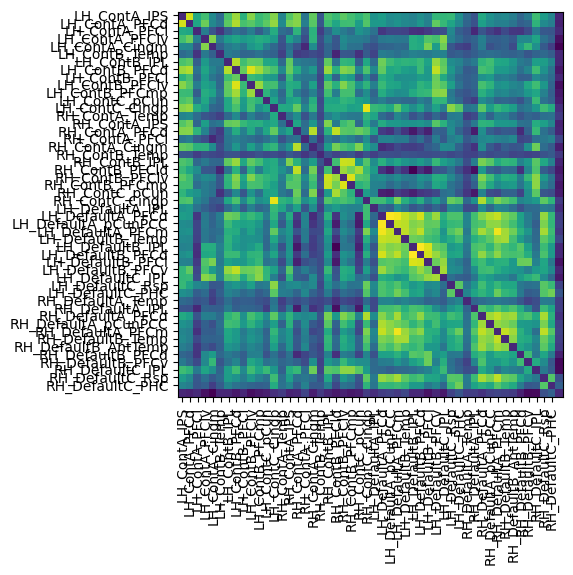

In [7]:
# Create lists for the corresponding names of the ROIs
fpn_labels = ['LH_ContA_Temp', 'LH_ContA_IPS', 'LH_ContA_PFCd', 'LH_ContA_PFCl', 'LH_ContA_PFClv', 'LH_ContA_Cingm', 'LH_ContB_Temp', 'LH_ContB_IPL', 'LH_ContB_PFCd', 'LH_ContB_PFCl', 'LH_ContB_PFClv', 'LH_ContB_PFCmp', 'LH_ContC_pCun', 'LH_ContC_Cingp', 'RH_ContA_Temp', 'RH_ContA_IPS', 'RH_ContA_PFCd', 'RH_ContA_PFCl', 'RH_ContA_Cingm', 'RH_ContB_Temp', 'RH_ContB_IPL', 'RH_ContB_PFCld', 'RH_ContB_PFClv', 'RH_ContB_PFCmp', 'RH_ContC_pCun', 'RH_ContC_Cingp']
dmn_labels = ['LH_DefaultA_IPL', 'LH_DefaultA_PFCd', 'LH_DefaultA_pCunPCC', 'LH_DefaultA_PFCm', 'LH_DefaultB_Temp', 'LH_DefaultB_IPL', 'LH_DefaultB_PFCd', 'LH_DefaultB_PFCl', 'LH_DefaultB_PFCv', 'LH_DefaultC_IPL', 'LH_DefaultC_Rsp', 'LH_DefaultC_PHC', 'RH_DefaultA_Temp', 'RH_DefaultA_IPL', 'RH_DefaultA_PFCd', 'RH_DefaultA_pCunPCC', 'RH_DefaultA_PFCm', 'RH_DefaultB_Temp', 'RH_DefaultB_AntTemp', 'RH_DefaultB_PFCd', 'RH_DefaultB_PFCv', 'RH_DefaultC_IPL', 'RH_DefaultC_Rsp', 'RH_DefaultC_PHC']
all_labels = fpn_labels + dmn_labels

def plot_fn(fn_file_path, axis_labels):
    mtx = np.load(fn_file_path)
    plt.figure(figsize=(5,5))
    plt.imshow(mtx)
    x_ticks = plt.xticks(range(len(axis_labels)-1), axis_labels[1:], rotation=90)
    y_ticks = plt.yticks(range(len(axis_labels)-1), axis_labels[1:])

plot_fn("/home/chanae/thesis/functional_matrices/130619/functional_matrix_Yeo.npy", all_labels)